In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = '/home/omarioni/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime2.dat')
lbar_M31gd = M31_gd[:,1]

49.9760023834
1709


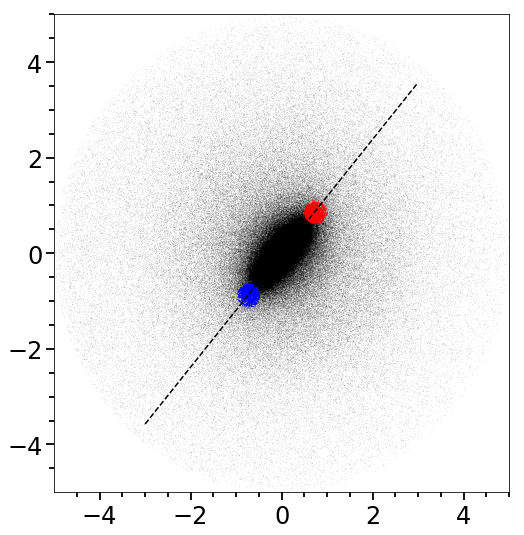

In [3]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng 
from scipy.stats import mode


h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')


path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]

path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,495,-1)
for isnap in snapshot:
    snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,1):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        IDs  = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Ids'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        t = tiempo.conv(z, h, omega_lambda, omega_matter)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)

        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
        mstr = mstr/h

        r200 = r200*aexp[isnap]/h
        rgal = 0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])

        Mc_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        cincuenta, = np.where(razon < 0.5)

        r50 = r_sort[cincuenta][-1]              

    #------------------masa total en r200 (Mvir)--------------------------         
        veloc,=np.where(r<r50)

    #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        rn = np.sqrt(xn**2 + yn**2 + zn**2)
        
        mask, = [np.where(rn<5.)]
        xx = xn[mask]
        yy = yn[mask]
        zz = zn[mask]
        ID = IDs[mask]
        
        corte,=np.where(r<3*aexp[isnap])
        A2max, rmax, phimax = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)
        
        R1 = np.sqrt((xx-(lbar_M31gd[496-isnap]-0.25)*np.cos(phimax))**2 + (yy-(lbar_M31gd[496-isnap]-0.25)*np.sin(phimax))**2 + zz**2)
        R2 = np.sqrt((xx+(lbar_M31gd[496-isnap]-0.25)*np.cos(phimax))**2 + (yy+(lbar_M31gd[496-isnap]-0.25)*np.sin(phimax))**2 + zz**2)
        tita = np.arctan2(yy,xx)
        
#         print max(tita), min(tita)

        print phimax*180/np.pi
    
        mask1, = np.where(R1<0.25)
        
        mask2, = np.where(R2<0.25)
        
        IDred = ID[mask1]
        IDblue = ID[mask2]
        
        print len(IDred)
        
        pend = np.tan(phimax)
        
        x = np.arange(-3,4)
        y = x* pend
        
        fig=plt.figure(1,figsize=(8,8))
        fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
        ax1=fig.add_subplot(111)
        ax1.plot(xx,yy,'.', markersize=0.05, color='k')
        ax1.plot(xx[mask1],yy[mask1],'.', markersize=0.5, color='r')
        ax1.plot(xx[mask2],yy[mask2],'.', markersize=0.5, color='b')
        ax1.plot(x,y,'k--')
        #plt.axis('off')
        #ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
        #ax1.set_xticklabels([])
        #ax1.set_yticklabels([])
        ax1.set_xlim(-5,5)
        ax1.set_ylim(-5,5)
#         plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
#         plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
        ax1.minorticks_on()
        ax1.tick_params( labelsize=24)
        ax1.tick_params('both', length=5, width=1.8,which='minor')
        ax1.tick_params('both', length=8, width=1.8,which='major')

        plt.show()
        #plt.clf()
        
#         phimax2 = phimax*180./np.pi
        
#         path3 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
    
#         archivo1 =  open(path3+'phi_time.dat','a')
#         archivo1.write(str('%12.6f'% t) +'\t'+
#                        str('%12.6f'% phimax2) +'\n')
#         archivo1.close()

-48.0146213556


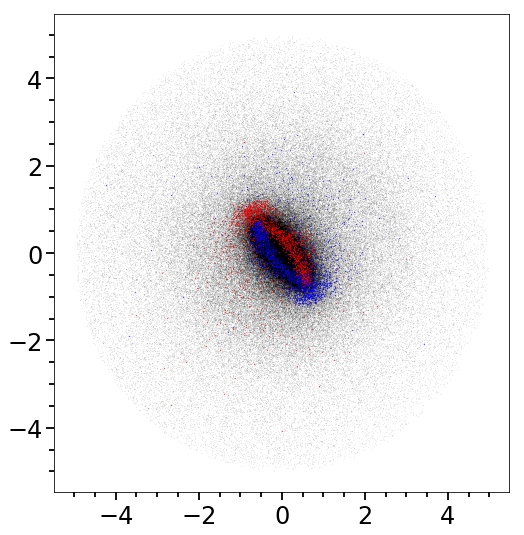

-0.843642249703
2.34265172482
-48.0146213556


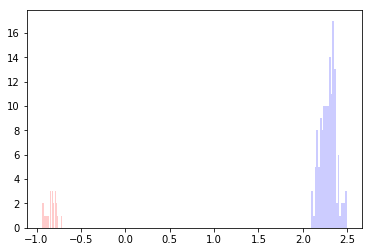

In [4]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
from scipy.stats import mode

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')


path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]

path = '/mnt/is2/alejandro/ornella/'

snapshot=range(495,494,-1)
for isnap in snapshot:
    snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,1):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        IDs  = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Ids'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        t = tiempo.conv(z, h, omega_lambda, omega_matter)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)

        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
        mstr = mstr/h

        r200 = r200*aexp[isnap]/h
        rgal = 0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])

        Mc_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        cincuenta, = np.where(razon < 0.5)

        r50 = r_sort[cincuenta][-1]              

    #------------------masa total en r200 (Mvir)--------------------------         
        veloc,=np.where(r<r50)

    #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        mask, = [np.where(r<5.)]
        xx = xn[mask]
        yy = yn[mask]
        zz = zn[mask]
        
        corte,=np.where(r<3*aexp[isnap])
        A2max, rmax, phimax = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)
        print phimax*180/np.pi
#         Rcirc = np.sqrt(xx**2 + yy**2)
        tita = np.arctan2(yy,xx)
        
#         print max(tita), min(tita)
    
#         print phimax*180/np.pi
#         mask1, = np.where((Rcirc < lbar_M31gd) & (Rcirc > lbar_M31gd-0.8) & 
#                           (tita < phimax+0.3) & (tita > phimax-0.3))
        
#         mask2, = np.where((Rcirc < lbar_M31gd) & (Rcirc > lbar_M31gd-0.8) &
#                           (tita < phimax-np.pi+0.3) & (tita > phimax-np.pi-0.3) )
        

        mask1 = np.isin(IDs[mask],IDred)
        mask2 = np.isin(IDs[mask],IDblue)
        
        R1 = np.sqrt((xx[mask1]-(lbar_M31gd[496-isnap]-0.25)*np.cos(phimax))**2 + (yy[mask1]-(lbar_M31gd[496-isnap]-0.25)*np.sin(phimax))**2 + zz[mask1]**2)
        R2 = np.sqrt((xx[mask1]+(lbar_M31gd[496-isnap]-0.25)*np.cos(phimax))**2 + (yy[mask1]+(lbar_M31gd[496-isnap]-0.25)*np.sin(phimax))**2 + zz[mask1]**2)
        mask11, = np.where(R1<0.25)
        mask22, = np.where(R2<0.25)
        
#         print len(mask1)
        
        fig=plt.figure(1,figsize=(8,8))
        fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
        ax1=fig.add_subplot(111)
        ax1.plot(xx,yy,'.', markersize=0.05, color='k')
        ax1.plot(xx[mask1],yy[mask1],'.', markersize=0.5, color='r')
#         ax1.plot(xx[mask1][mask11],yy[mask1][mask11],'.', markersize=1, color='g')
#         ax1.plot(xx[mask1][mask22],yy[mask1][mask22],'.', markersize=1, color='g')
        ax1.plot(xx[mask2],yy[mask2],'.', markersize=0.5, color='b')
#         ax1.plot(x,f(x),'k--')
        #plt.axis('off')
        #ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
        #ax1.set_xticklabels([])
        #ax1.set_yticklabels([])
#         ax1.set_xlim(-15,15)
#         ax1.set_ylim(-15,15)
#         plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
#         plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
        ax1.minorticks_on()
        ax1.tick_params( labelsize=24)
        ax1.tick_params('both', length=5, width=1.8,which='minor')
        ax1.tick_params('both', length=8, width=1.8,which='major')

        plt.show()
        
        plt.hist(tita[mask1][mask11],alpha=0.2, color ='r',bins=20)
        plt.hist(tita[mask1][mask22],alpha=0.2, color ='b',bins=20)
        
        qq1 =np.histogram(tita[mask1][mask11], bins=20)
        
        elarg1= np.argmax(qq1[0])
        medbin1 = np.zeros(20)
        for i in range(0,20):
            medbin1[i] = (qq1[1][i+1]+qq1[1][i])/2. 
        print medbin1[elarg1]
        
        qq2 =np.histogram(tita[mask1][mask22], bins=20)
        
        elarg2= np.argmax(qq2[0])
        medbin2 = np.zeros(20)
        for i in range(0,20):
            medbin2[i] = (qq2[1][i+1]+qq2[1][i])/2. 
        print medbin2[elarg2]
        
        dif = abs(medbin1[elarg1] - phimax)
        
        if dif > np.pi/2:
            phimax = phimax - np.pi
        
        print phimax*180/np.pi
            

In [31]:
path = '/home/omarioni/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime2.dat')
lbar_M31gd = M31_gd[:,1]

In [47]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng 
from scipy.stats import mode


h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')


path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]

path = '/mnt/is2/alejandro/ornella/'

for isnap in range(495,490,-1):
#     print isnap
    snap1 = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    cm   = snap1['subhalo_000/Center'].value
    r200 = snap1['subhalo_000/R200'].value

    pstr = snap1['subhalo_000/Str/Coordinates'].value
    IDs  = snap1['subhalo_000/Str/Ids'].value
    mstr = snap1['subhalo_000/Str/Masses'].value
    vel  = snap1['subhalo_000/Str/Velocities'].value

    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    t = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
    mstr = mstr/h

    r200 = r200*aexp[isnap]/h
    rgal = 0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((mstr[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    cincuenta, = np.where(razon < 0.5)

    r50 = r_sort[cincuenta][-1]              

#------------------masa total en r200 (Mvir)--------------------------         
    veloc,=np.where(r<r50)

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    mask, = [np.where(r<5.)]
    xx = xn[mask]
    yy = yn[mask]
    zz = zn[mask]
    ID = IDs[mask]

    path3 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
    phi = np.loadtxt(path3+'phi_time.dat')
    phimax = phi[496-isnap,1]
        
    Rcirc = np.sqrt(xx**2 + yy**2)
    tita = np.arctan2(yy,xx)

    
    mask1, = np.where((Rcirc < lbar_M31gd[496-isnap]) & (Rcirc > lbar_M31gd[496-isnap]-0.8) & 
                      (tita < phimax+0.5) & (tita > phimax-0.5))

    mask2, = np.where((Rcirc < lbar_M31gd[496-isnap]) & (Rcirc > lbar_M31gd[496-isnap]-0.8) &
                      (tita < phimax-np.sign(phimax)*np.pi+0.5) & (tita > phimax-np.sign(phimax)*np.pi-0.5))

    IDred = ID[mask1]
    IDblue = ID[mask2]
    
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------

    snap2 = h5py.File(path+'outputs_1/snap_'+str('%03d'%(isnap-1))+'.h5py', 'r')
    
#     print snap2
    
    cm   = snap2['subhalo_000/Center'].value
    r200 = snap2['subhalo_000/R200'].value

    pstr = snap2['subhalo_000/Str/Coordinates'].value
    IDs  = snap2['subhalo_000/Str/Ids'].value
    mstr = snap2['subhalo_000/Str/Masses'].value
    vel  = snap2['subhalo_000/Str/Velocities'].value

    z = a0/aexp[isnap-1] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    t = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap-1]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap-1]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap-1]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp[isnap-1]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap-1]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap-1]) + Ht *zstr/1000.

#----------------------masas----------------------------
    mstr = mstr/h

    r200 = r200*aexp[isnap-1]/h
    rgal = 0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((mstr[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    cincuenta, = np.where(razon < 0.5)

    r50 = r_sort[cincuenta][-1]              

#------------------masa total en r200 (Mvir)--------------------------         
    veloc,=np.where(r<r50)

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    mask, = [np.where(r<5.)]
    xx = xn[mask]
    yy = yn[mask]

    corte,=np.where(r<3*aexp[isnap-1])
    A2max, rmax, phimax = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)

    tita = np.arctan2(yy,xx)

    mask1 = np.isin(IDs[mask],IDred)
#     mask2 = np.isin(IDs[mask],IDblue)

    nbin = 20 
    
    qq1 =np.histogram(tita[mask1], bins=nbin)
    arg1= np.argmax(qq1[0])
    medbin1 = np.zeros(nbin)
    
    for i in range(0,nbin):
        medbin1[i] = (qq1[1][i+1]+qq1[1][i])/2. 
#         medbin2[i] = (qq2[1][i+1]+qq2[1][i])/2. 

    dif = abs(medbin1[arg1] - phimax)

    if dif > np.pi/2:
        phimax = phimax - np.pi

    phimax2 = phimax*180/np.pi

    print phimax2
    
    path3 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
    
    archivo1 =  open(path3+'phi_time.dat','a')
    archivo1.write(str('%12.6f'% t) +'\t'+
                   str('%12.6f'% phimax2) +'\n')
    archivo1.close()

34.7109530601
-66.7053349816
16.0190697642
-80.5409213343
1.71968400505


In [42]:
    path3 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
    phi = np.loadtxt(path3+'phi_time.dat')
    phimax = phi[1]
    print phimax

49.976002
